In [1]:
# %load /Users/xichen/Library/Mobile\ Documents/com~apple~CloudDocs/computer_bootstrap/my_imports.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy.io import mmread
import matplotlib.pyplot as plt
from collections import Counter

Kelly = ['#af2337', '#ecc342', '#2967a0', '#2f3c28', '#96b437',
         '#da93ab', '#e58932', '#80598f', '#7e331f', '#3b855a',
         '#c0b286', '#a9c9ed', '#ec977f', '#848482', '#604628',
         '#d26034', '#a64c6b', '#dbd245', '#eba83b', '#5d5092',
         '#222222', '#f2f3f4']

GreenArmytage = ['#e3a7fa', '#3575d5', '#8d4418', '#440b59', '#191919', '#285a35',
                 '#6aca5b', '#f6cda0', '#808080', '#b1fcbb', '#8c7c26', '#a8ca3f',
                 '#af2785', '#13347b', '#51a12f', '#f1acbb', '#4b651a', '#e73329',
                 '#8deef0', '#48978f', '#e7fd7d', '#0c1ff5', '#8a1a11', '#fffe92',
                 '#f9e14c', '#e95d2a']

Chromsomes = ['#fefb57', '#c15662', '#b3bff5', '#75f9f0', '#ea8a33',
              '#9e5dca', '#946e6b', '#f3c985', '#f0feee', '#afe347',
              '#5dc5e5', '#e73ff0', '#e23022', '#ed7fc5', '#4f8283',
              '#af35f5', '#49a9f6', '#ea3584', '#94f8b8', '#4d6df6',
              '#eafdad', '#f6c6ec', '#5d8841', '#74f973']

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=Kelly)
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.markerscale'] = 1
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['figure.dpi'] = 100

In [2]:
cells = [i.strip() for i in open('ATAC/full_analysis/outs/filtered_mtx/barcodes.tsv')]

In [3]:
len(cells)

6429

In [4]:
hs = pd.read_csv('ATAC/full_analysis/outs/per_cell_barcode_total_fragment_count_GRCh38.tsv',
                 header=None, names=['count_hs', 'cb'], index_col='cb', sep='\t')
mm = pd.read_csv('ATAC/full_analysis/outs/per_cell_barcode_total_fragment_count_mm10.tsv',
                 header=None, names=['count_mm', 'cb'], index_col='cb', sep='\t')
df = pd.concat([hs, mm], axis=1)
df = df.loc[cells,]
df['total'] = df['count_hs'] + df['count_mm']

/home/xichen/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xichen/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


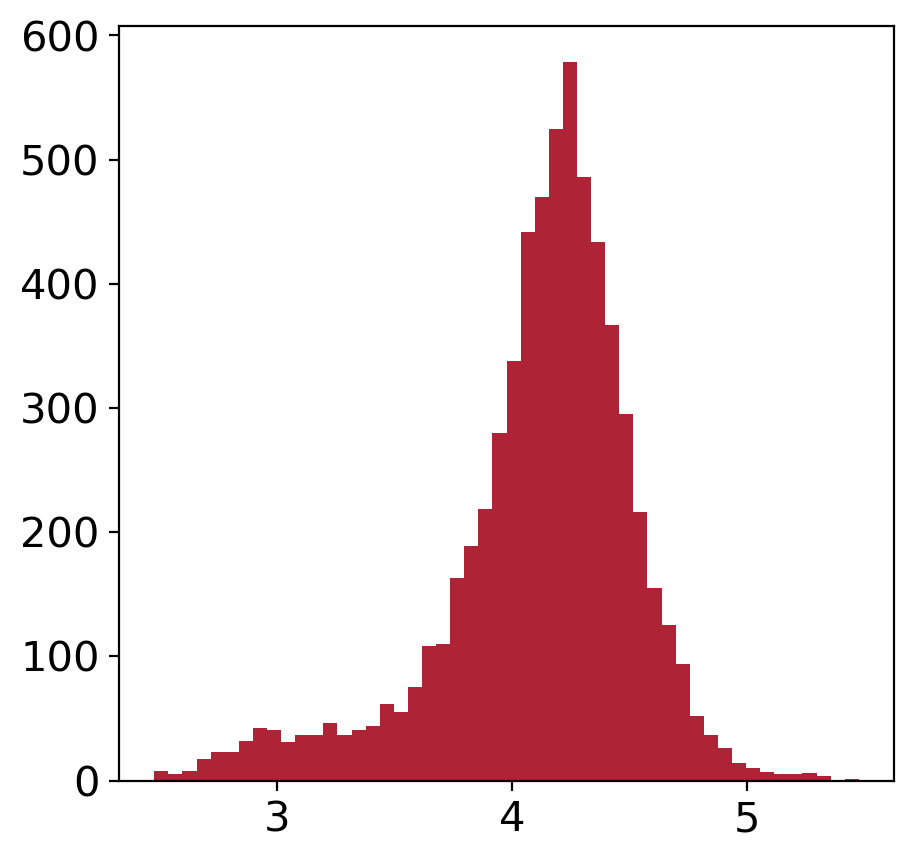

In [5]:
plt.figure(figsize=(5,5))
plt.hist(np.log10(df['total']), 50)
plt.show()

In [6]:
df['species'] = 0
df.loc[df['count_hs']/df['total'] > 0.9, 'species'] = 'Human'
df.loc[df['count_mm']/df['total'] > 0.9, 'species'] = 'Mouse'
df.loc[df.query('total < 1000').index, 'species'] = 'Low yield'
df.replace({'species' : {0 : 'Mix'}}, inplace=True)

In [7]:
df.species.value_counts()

Mouse        3056
Human        2653
Mix           533
Low yield     187
Name: species, dtype: int64

In [8]:
533/(3056 + 2653 + 533)

0.08538929830182634

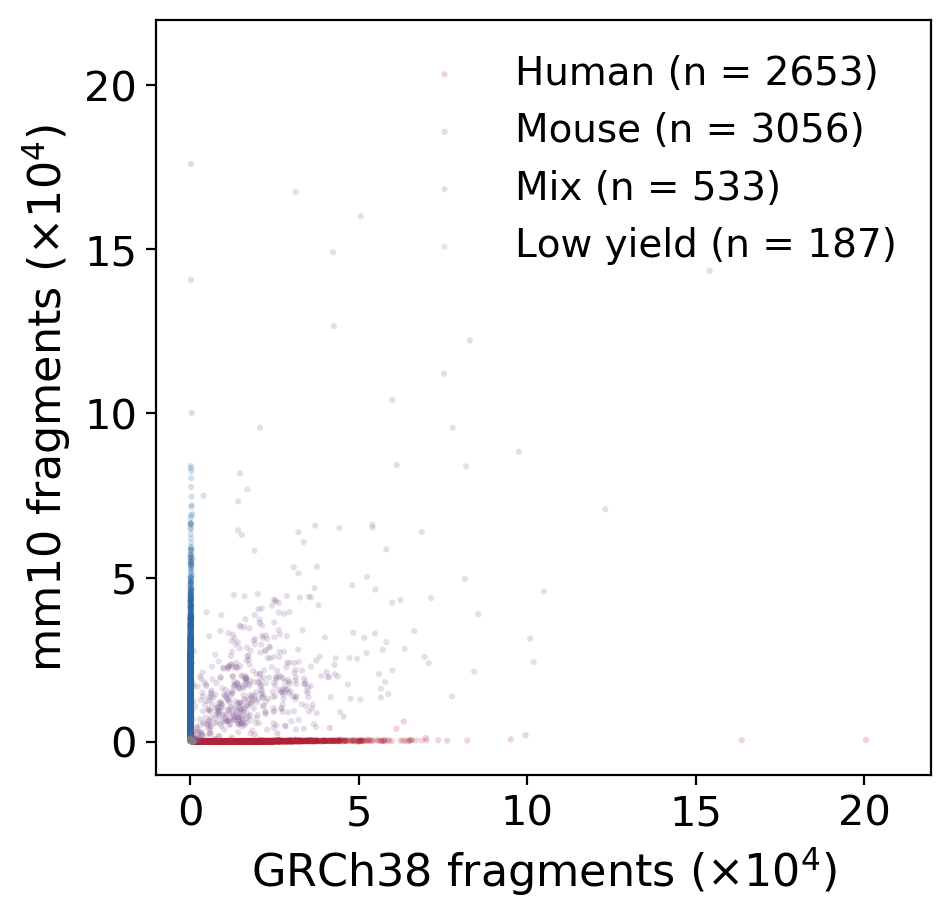

In [9]:
plt.figure(figsize=(5,5))
for sp, c in zip(['Human', 'Mouse', 'Mix', 'Low yield'], ['#af2337', '#2967a0', '#80598f', '#848482']):
    plt.scatter(df.query('species == @sp')['count_hs'], df.query('species == @sp')['count_mm'],
                c=c, ec=None, s=5, label='%s (n = %s)' % (sp, df.species.value_counts()[sp]), alpha=.2)
plt.legend(frameon=False, markerscale=1)
plt.xlim(-10000, 220000)
plt.ylim(-10000, 220000)
plt.xticks([0, 50000, 100000, 150000, 200000], ['0', '5', '10', '15', '20'])
plt.yticks([0, 50000, 100000, 150000, 200000], ['0', '5', '10', '15', '20'])
plt.xlabel(r'GRCh38 fragments ($\times 10^4$)')
plt.ylabel(r'mm10 fragments ($\times 10^4$)')
plt.savefig('barnyard_droplet_atac_full.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [10]:
count = mmread('ATAC/full_analysis/outs/filtered_mtx/matrix.mtx')
cols = [i.strip() for i in open('ATAC/full_analysis/outs/filtered_mtx/barcodes.tsv')]

sc_count = pd.DataFrame(data=count.toarray(),
                        columns=cols)

In [11]:
nih = sc_count.loc[:, df.query('species == "Mouse"').index]
hek = sc_count.loc[:, df.query('species == "Human"').index]

In [12]:
!mkdir -p ATAC/full_analysis/outs/HEK293T
!mkdir -p ATAC/full_analysis/outs/NIH3T3

for cm, ct in zip([hek, nih], ['HEK293T', 'NIH3T3']):
    metrics = pd.DataFrame(data = cm.sum(0), columns = ['nCounts'])
    metrics['nFeatures'] = (cm > 0).sum(0)
    metrics.to_csv('ATAC/full_analysis/outs/%s/metrics.csv' % ct, index_label='cell')

nCounts      14890.5
nFeatures     6348.5
dtype: float64